# Day 3 - Tensorflow Working Session 

In [5]:
# Usual imports
import numpy as np
import tensorflow as tf

# Let's import the Keras library
from tensorflow import keras

# Let's import the OS to use specific features 
import os 

# Plotting imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# To make this notebook stable across platforms, run this
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Why Convolutional Neural Networks (CovNets)?

The multi-layer perceptron doesn't work for images (specifically for classification tasks) for two main reasons:

1) There are too many weights! For an image that is $256\times256\times3$ pixels ($3$ is since it's a color image) we will have $(256*256*3)^{2} = 38.7$ billion weights for one fully-connected layer! Even with $\backsim1000$ neurons in the first layer we would need $\backsim200$ million weights. Even if we could train something this large we would **overfit**. 

2) Does not take advantage of the spatial invariance (i.e. a cat is a cat). This means it doesn't matter if the object is in the top-left or bottom-right of the image.

Basic building blocks of the convolutional neural network (CNN): 

 - convolution step
 - subsampling step (pooling layer)
 - optional extra filter or nonlinearity

### Convolutions


***1-D Covolution:***

A convolution is a sliding window that essentially computes a dot-product. Take the 1-D image below for example (padded with zeros):

<img src="images/convolutions.jpg">

In general: 

$y_k=\sum_{i=-1}^{1}w_{i}x_{k+i}$ for all $k$. 

We can treat the convolutional kernel (or filter), $w$, like a small image. 

Here are some examples of filters:

<img src="images/filter_examples.jpg">

***2-D Convolution***

We can also perform convolutions in 2-D:

<img src="images/2d_convolution.jpg">

Here the input image is $X\in\mathbb{R}^{M\times N}$ 
and the convolutional kernel or filter is $W\in\mathbb{R}^{F_{H}\times F_{W}}$.  The filter also slides over the $M\times N$ spatial map.  

The output will be:

$Z_{i,j} = \sum_{u=0}^{F_{H}-1}\sum_{v=0}^{F_{W}-1}W_{u,v}\cdot X_{i+u,j+v}$

where: 
 - $Z\in\mathbb{R}^{M\times N}$ is the output also known as the *activation map*.
 - $F_{H},F_{W}$ are the filter heights and widths also know as the *kernel size* or *receptive field*. Most of the time, $F_{H}=F_{W}=F$ 
 - $W_{u,v}$ is the filter also known as the *convolutional kernel*.
 - $X_{i+u,j+v}$ is the input image where the image indices add to the weight indices.


*Example* 

$F_{H}=F_{W}=3$ then the outputs $Z_{i,j}$ are:

$\begin{array}{cols}
Z_{0,0} = W_{0,0}X_{0,0}+W_{0,1}X_{0,1}+W_{0,2}X_{0,2}+W_{1,0}X_{1,0}+W_{1,1}X_{1,1}+W_{1,2}X_{1,2}
+W_{2,0}X_{2,0}+W_{2,1}X_{2,1}+W_{2,2}X_{2,2}\\ 
Z_{0,1} = W_{0,0}X_{0,1}+W_{0,1}X_{0,2}+W_{0,2}X_{0,3}+W_{1,0}X_{1,1}+W_{1,1}X_{1,2}+W_{1,2}X_{1,3}
+W_{2,0}X_{2,1}+W_{2,1}X_{2,2}+W_{2,2}X_{2,3}\\ 
\vdots \\
Z_{M-1,N-2} = W_{0,0}X_{M-1,N-2}+W_{0,1}X_{M-1,N-1}\\
Z_{M-1,N-1} = W_{0,0}X_{M-1,N-1}.\end{array}$


*Strides*

We can also use a **stride**, where we don't apply a convolution at every pixel and instead skip by the stride, $S$. 

The output will now be:
$Z_{i,j} = \sum_{u=0}^{F_{H}-1}\sum_{v=0}^{F_{W}-1}W_{u,v}\cdot X_{Si+u,Sj+v}$

where: 
 - $S$ is the *stride* 
 - $Z\in\mathbb{R}^{\frac{M}{S}\times \frac{N}{S}}$ is the strided output also known as the *activation map*.
 - $F_{H},F_{W}$ are the filter heights and widths also know as the *kernel size* or *receptive field*.
 - $W_{u,v}$ is the filter also known as the *convolutional kernel*.
 - $X_{i+u,j+v}$ is the input image where the image indices add to the weight indices.

### Building blocks of a CovNet

***Convolutional Layers***

Convolutional layers are the foundation of CovNets.  Each neuron in the convolutional layer is connected to a local region of the input volume. The spatial extent of this connectivity is a hyperparameter is due to the receptive field of the neuron (also called the filter size). 
 

The extent of the connectivity along the depth axis is always equal to the depth of the input volume. The connections are local along width and height dimension, but always full along the entire depth of the input volume.

<img src="images/cnn.jpeg">

In the picture above, every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (RGB channels).

<img src="images/depthcol.jpeg">

Above we see an example of an input volume in red (e.g. a $32\times32\times3$ CIFAR-10 image), and an example output volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (all color channels). Note, there are multiple neurons ($K=5$ in this example) along the depth, all looking at the same region in the input.

***Convolutional Kernels or Filters***

Note a layer full of neurons using the same filter gives you a *feature or activation map*, which highlights the areas in an image that are most similar to the filter. 

During training the CNN finds the most useful filters for it's task and learns to combine them into more complex patterns (a cross is an area in an image where both the vertical and horizontal filters are active). 


***Pooling Layers***

We can use a pooling layer to reduce the spatial size of the image, which reduces the number of parameters and computation in the network. This controls overfitting as well. The most common is a $2\times2$ filter with a stride of 2 downsamples for every depth slice in the input by $2$ along width and height. This discards $75\%$ of the activations.

<img src="images/pool.jpeg">

In picture above, the input volume of size $224\times224\times64$ is pooled with filter size $2$, stride $2$ into an output volume of size $112\times112\times64$. Notice that the volume depth is preserved.

<img src="images/maxpool.jpeg">

The most common downsampling operation is max, giving rise to max pooling, here shown with a stride of $2$. That is, each max is taken over $4$ numbers (little $2\times2$ square).


### Hyperparameters for CovNets

In order to determine the size of the output volume, the hyperparameters that we must pick are: **depth**, **stride**, **zero-padding**.

1. **Depth**, $K$, corresponds to the number of filters we want to use (each looking for unique feature in image). The **depth column** refers to the the set of neurons . that are looking at the same region of the input. 
2. **Stride**, $S$.
3. **Zero-padding**, $P$, correspnds to padding the input volume with zeros around the border. Zero padding allow us to control the spatial size of the output volumes.

***Sizing CovNets***

We can size the output volume using the input image size $W$, recepetive field size $F$, the stride size $S$, and the zero padding on the border $P$. 

The number of neurons to "fit" in the output volume is given by: 

$\frac{W-F+2P}{S} + 1$.


Setting zero padding to be:

$P=\frac{F−1}{2}$ when the stride is $S=1$ ensures that the input volume and output volume will have the same size spatially.  

*Example: 1-D*

In this example there is only one spatial dimension (x-axis), one neuron with a receptive field size of $F = 3$, the input size is $W = 5$, and zero padding of $P = 1$.

<img src="images/stride.jpeg">

On the left the neuron strided across the input in stride of $S = 1$, giving output of size $(5 - 3 + 2)/1+1 = 5$. The neurons on the right use a stride of $S = 2$, giving output of size $(5 - 3 + 2)/2+1 = 3$. 

*Example: AlexNet*

Input image dimensiions are $227\times227\times3$. Therefore, 
$W = 227$.

The hyperparameters that were chosen for the first convolutional layer are $F=11, S=4, P=0$. 

We also pick depth $K=96$ so there are $96$ different filters. 

Therefore, the number of neurons to fit is $\frac{(227-11)}{4}+1=55$.

The output dimensions of the first convolutional layer is $55\times55\times96$. Each of the $55\times55\times96$ neurons in the volume connected to region of $11\times11\times3$ input volume. 

Each depth column will have $96$ neurons. Each depth column will be connected to the same $11\times11\times3$ region of input but with different weights. There are $55\cdot55\cdot96 = 290,400$ neurons in the first convolutional layer. 

Each neuron will have $11\cdot11\cdot3=363\>\text{weights} + 1\>\text{bias}$. Total number of parameters will be $290,400\cdot364 = 105,705,600$! 

If we have a feature to compute a one spatial position then it should be reasonalble to use the same feature to calculate a different position in the feature map.

There are 96 depth slices for our first convolutional layer. Let's constrain the neurons in each depth slice to use the same weights and bias. Therefore, we have instead $96$ unique weights. There are now $11\cdot11\cdot396=34,848\>\text{weights} + 96\> \text{biases}$. 

This is called *parameter sharing*. 

Therefore, each depth column $1\times1\times96$ of the layer will have $96$ neurons that will have different weights but use the same receptive field. Each $55\times55\times1$ depth slice will have the same weights since it's using the same same filter but a different receptive field is used over the width and height of the slice. 

*Example: Feature Map Calculations* 

Depth columns at position $i,j$ is the activation at $X[i,j,:]$.

Depth slice or feature map at depth $k$, would be the activation given by $X[:,:,k]$.

Suppose the shape of our input volume $X$ is $11\times11\times4)$, the filter size is $F=5$, and the stride is $S=2$. 

The output volume would have a spatial size of $(11-5)/2+1=4$ giving the output volume, $Z$, a height and width of 4. 

The first feature map is:

$\begin{array}{cols}
Z[0,0,0] = \sum_{i=0}^{4}\sum_{j=0}^{4}X[i,j,:] \circ W_{0} + b_{0}\\
Z[1,0,0] = \sum_{i=2}^{6}\sum_{j=0}^{4}X[i,j,:] \circ W_{0} + b_{0}\\
Z[2,0,0] = \sum_{i=4}^{8}\sum_{j=0}^{4}X[i,j,:] \circ W_{0} + b_{0}\\
Z[3,0,0] = \sum_{i=6}^{10}\sum_{j=0}^{4}X[i,j,:] \circ W_{0} + b_{0}\end{array}$
 
The above $\circ$ denotes a element-wise multiplication between arrays (Hadmard product). Here $W_{0}$ is assummed to be the weight vector of that neuron and the shape of $W_{0}$ is $5\times5\times4$. 

The summation index for $i,j$ runs from $0$ to $4$ or length of $5$ since $F=5$. We are increasing the starting index $i$ in steps of $2$ because $S=2$. Here we are striding along $i$ only but can also stride along $j$ as well.

The second feature map is where we are computing a different set of features maps and so $W_{1}$ is now used:

$\begin{array}{cols}
Z[0,0,1] = \sum_{i=0}^{4}\sum_{j=0}^{4}X[i,j,:] \circ W_{1} + b_{1}\\
Z[1,0,1] = \sum_{i=2}^{6}\sum_{j=0}^{4}X[i,j,:] \circ W_{1} + b_{1}\\
Z[2,0,1] = \sum_{i=4}^{8}\sum_{j=0}^{4}X[i,j,:] \circ W_{1} + b_{1}\\
Z[3,0,1] = \sum_{i=6}^{10}\sum_{j=0}^{4}X[i,j,:] \circ W_{1} + b_{1}\end{array}$

Using summation notation we can write this more generally as:

$z_{i,j,k} = b_k + \sum\limits_{u=0}^{F-1}\sum\limits_{v=0}^{F-1}\sum\limits_{k'=0}^{K'-1}x_{i',j',k'}\cdot w'_{u,v,k',k} $ 

where $i'= S\cdot i +u$ and $j'= S\cdot j +v$ 
 - $z_{i,j,k}$ is the output of the neuron in row $i$, column $j$ in feature map $k$ of the current convolutional layer, $L$
 - $S$ is the stride size, $F$ is the receptive field size, $K'$ is the depth size or number of feature maps in the previous layer ($L-1$)
 - $x_{i',j',k'}$ is the output of the neuron located in layer $(L-1)$, row $i'$, column $j'$, feature map $k'$ (or channel $k'$ if the previous layer is the input layer).
 - $b_k$ is the bias term for the feature map $k$ in layer $L$. You can think of it as a knob that tweaks the overall brightness of the feature map $k$
 - $w'_{u,v,k',k}$ is the connection weight between any neuron in feature map $k$ of the layer $L$ and its input located at row $u$, column $v$ (relative the the neuron's receptive field), and feature map $k'$

### CovNet Layer Patterns

For example, here are some common ConvNet architectures you may see that follow this pattern:
`INPUT` is input volume or image
`FC` is fully-connected layer 
`CONV` is the convolutional layer 
`RELU` is the rectified linear unit
`POOL` is pooling layer.

1) `INPUT -> FC` 

Implements a linear classifier. 

2) `INPUT -> CONV -> RELU -> FC`

3) `INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC`

Here we see that there is a single CONV layer between every POOL layer.

4) `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC` 

Here we see two `CONV` layers stacked before every `POOL` layer. This is generally a good idea for larger and deeper networks, because multiple stacked `CONV` layers can develop more complex features of the input volume before the destructive pooling operation.

Intuitively, stacking `CONV` layers with tiny filters as opposed to having one `CONV` layer with big filters allows us to express more powerful features of the input, and with fewer parameters.

### Rules of Thumb 

1) The input layer (that contains the image) should be divisible by $2$ many times. Common numbers include $32$ (e.g. CIFAR-10), $64$, $96$ (e.g. STL-10), or $224$ (e.g. common ImageNet ConvNets), $384$, and $512$.

2) The layers should be using small filters (e.g. $3\times3$ or at most $5\times5$), using a stride of $S=1$. Crucially, padding the input volume with zeros in such way that the conv. layer does not alter the spatial dimensions of the input. That is, when $F=3$, then using $P=1$ will retain the original size of the input. When $F=5, P=2$. Generally, for any $F$ we have $P=\frac{F−1}{2}$ preserves the input size. 

3) The pool layers are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with $2\times2$ receptive fields (i.e. $F=2$), and with a stride of $2$ (i.e. $S=2$). Note that this discards exactly $75\%$ of the activations in an input volume (due to downsampling by $2$ in both width and height). 

## Tensorflow Implementation

In Tensorflow each input volume can be represented as a 3-D tensor with shape: 
`(height, width, channels)` 

where: 
 - `height` is the image pixel height
 - `width` is the image pixel width
 - `channels` is the number of image channels. 

If we are using a mini-batch then we can represent the input as a 4-D tensor of shape: 
`(mini_batch_size, height, width, num_channels)`.

The weights of the convolutional layer is represented as a 4-D tensor of shape 

`(rfield_height, rfield_width, num_feature_maps_prev_layer, bias_terms)`

where: 
 - `rfield_height` is the receptive field height
 - `rfield_width` is the receptive field width
 - `num_feature_maps_prev_layer` is the number of feature maps in previous layer
 -  `bias_terms` is the number of bias terms in current layer.

In [9]:
# Some utilities to plot grayscale and RGB images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

#### Simple Example

In [18]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imre

In [20]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [21]:
dataset.shape

(2, 427, 640, 3)

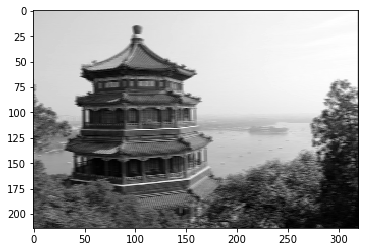

In [22]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:,3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

# Create a graph with the input X plus a convolutional layer 
# applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# strides = [batch_stride, stride_height, stride_width, stride_depth]
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:dataset})
    
plt.imshow(output[0, :, :, 1], cmap="gray") # Plot 1st image's 2nd feature map
plt.show()

If padding is set to "SAME" the convolutional layer uses zero padding if necessary. In this case the number of output neurons is equal to number of input neurons divided by the stride and rounded up. In this case, the padding options are input width=13, filter width=6, stride=5 and so `ceil(13/5)=3`. Zeros are added as evenly as possible around the inputs.

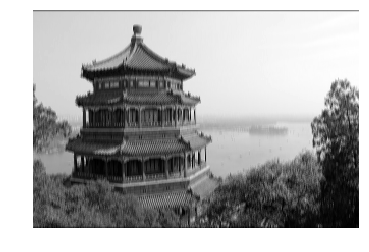

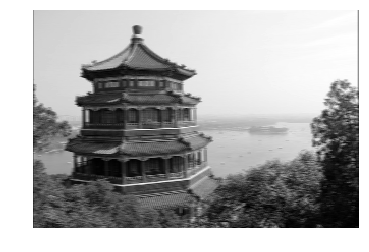

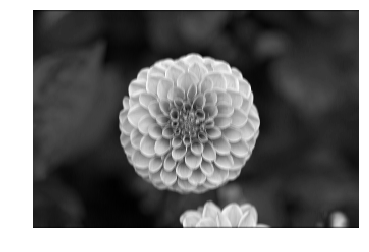

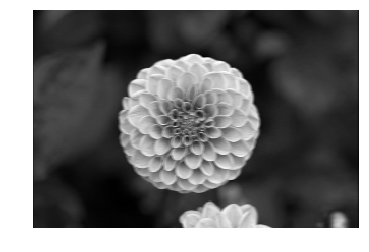

In [23]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

The `tf.layers.conv2d()` function creates the filters variable for you by giving it number of `filters` and  `kernel_size`. Tensorflow will initialize it randomly. It also created the bias and initializes it to 0. The following will create an input placeholder followed by a conv. layer with two $7\times 7$ feature maps, using a $2 \times 2$ strides.

In [25]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                       padding="SAME")

init= tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

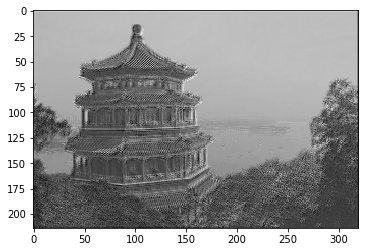

In [26]:
plt.imshow(output[0, :, :, 1], cmap="gray") #plot 1st image's feature map
plt.show()

***Pooling Layer***

Pooling layer works on every input channel independently so the output depth is the same as the input depth. You may also pool over the depth dimension, where the height and width are unchanged but the number of channels is reduced. 

In [27]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 #vertical line
filters[3, :, :, 1] = 1 #horizontal line

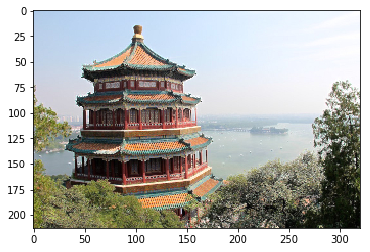

In [28]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
    
plt.imshow(output[0].astype(np.uint8))
plt.show()

The original image is:

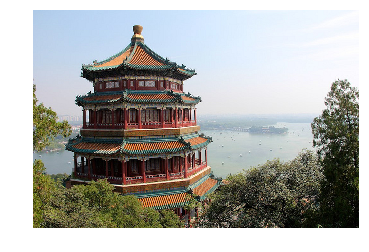

In [29]:
plot_color_image(dataset[0])
plt.show()

The max-pooled output is:

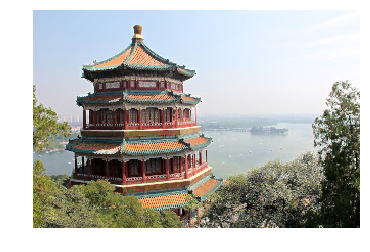

In [30]:
plot_color_image(output[0])
plt.show()

#### Example: MNIST

In [47]:
reset_graph()

# Height of the input image
height = 28
# Width of the input image
width = 28
channels = 1
n_inputs = height * width

# Hyperparamters for CONV layers
conv1_fmaps = 32   # number of feature maps/filters
conv1_ksize = 3    # the size of the recepetive field
conv1_stride = 1   # stride
conv1_pad = "SAME" # input/output size same

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps # pooling layer feature maps

n_fc1 = 64 # neurons in the FC1
n_outputs = 10

reset_graph()

# Inputs for model within context
with tf.name_scope("inputs"):
    # Placeholder variable for the input image
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    # Reshaped to [mini-batch, height, width, channels]
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    # Placeholder for labels
    y = tf.placeholder(tf.int32, shape=[None], name="y")

# CONV1: X -> CONV1 
# Here is filters sets the number of filters, 
# ksize sets the size of filter, 
# "VALID" paddding means no padding
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
# CONV2: CONV1 -> CONV2
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv")
# CONV2 -> POOL
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    # Need to "flatten" tensor for input to FC1 
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
# POOL -> FC1
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [48]:
# Load the data 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [49]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y:mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_cnn_mnist_model") 

0 Train accuracy: 0.99 Test accuracy: 0.9774
1 Train accuracy: 0.96 Test accuracy: 0.9799
2 Train accuracy: 0.99 Test accuracy: 0.986
3 Train accuracy: 0.98 Test accuracy: 0.9879
4 Train accuracy: 1.0 Test accuracy: 0.9887
5 Train accuracy: 0.99 Test accuracy: 0.9905
6 Train accuracy: 1.0 Test accuracy: 0.9877
7 Train accuracy: 1.0 Test accuracy: 0.9891
8 Train accuracy: 1.0 Test accuracy: 0.9879
9 Train accuracy: 1.0 Test accuracy: 0.9894


### Transfer Learning for Large Scale Classification 

Generally, it's not a good idea to train very large networks from scratch. Instead, we try to find an existing neural network that accomplishes a similar task to the one that you are trying to tackle. We will just reuse the lower layers of this network. This is called *transfer learning*. 

***Google's Inception Networks***

There can be a large variation in how many pixels an object in a image may occupy. The same object can be far away or close and sizing the correct kernel/field size for the convolution operation can be challenging. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally. Very large deep networks are prone to overfitting and large convolutions can be computationally expensive. The solution that was proposed by Google is the *Inception module*.

<img src="images/inception_naive.png">

Here the input signal is copied and fed to four different `CONV` layers, note the second level of layers all have different kernel sizes ($3\times3$, $5\times5$, $1\times1$) allowing them to capture patterns at different scales.  The network essentially would get a bit “wider” rather than “deeper”. 

Usually, a stride of 1 is used for the layers with SAME padding so the outputs have the same height and width as the inputs. This makes it possible to concatenate all the outputs along the depth dimension, which is shown as *filter concatenation* in the image above. This concatenate layer can be implemented in TensorFlow using `tf.concat()` operation with the `axis=3` (the depth axis).

The reason there are $1\times1$ kernels is that they are configured to output fewer features than the inputs serving as *bottleneck layers* meaning that they reduce the dimensionality before the computationally expensive $3\times3$, $5\times5$ convolutions occur. Also, each pair of $[1\times1$,$3\times3]$ and $[1\times1$,$5\times5]$ acts as a single powerful convulational layer. 

GoogLeNet has 9 such inception modules stacked linearly. It is 22 layers deep (27, including the pooling layers). It uses global average pooling at the end of the last inception module and won the ILSVRC14 competition. For more information please see https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf

In [34]:
# The image width, width, channels for the network
width = 299
height = 299
channels = 3

In [7]:
import os
import sys
import tarfile
from six.moves import urllib


TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_V4_URL = TF_MODELS_URL + "/inception_v4_2016_09_09.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")
INCEPTION_V4_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v4.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()
    
def fetch_pretrained_inception(version=4, path=INCEPTION_PATH):
    if version == 3:
        url = INCEPTION_V3_URL
        chk_path = INCEPTION_V3_CHECKPOINT_PATH
        model = "inception_v3.tgz"
    else:
        url = INCEPTION_V4_URL
        chk_path = INCEPTION_V4_CHECKPOINT_PATH
        model = "inception_v4.tgz"
    # If we already have a checkpoint path please return to caller
    if os.path.exists(chk_path):
        return
    # This will create a directory "path" as well as the 
    # intermediate directories, if exist_ok=True means directory
    # exists. 
    os.makedirs(path, exist_ok=True)
    # This will join the both of the strings 
    # tgz_path = /datasets/inception/inception_v3.tgz
    tgz_path = os.path.join(path, model)
    # Opens the "url", "tgz_path" is additional data sent to server,
    # and then report_hook is the timeout
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    # Opens the tarfile /datasets/inception/inception_v3.tgz
    inception_tgz = tarfile.open(tgz_path)
    # Extracts all on the path "datasets/inception" 
    inception_tgz.extractall(path=path)
    # Close the path
    inception_tgz.close()
    # Remove from OS
    os.remove(tgz_path)

In [8]:
fetch_pretrained_inception(3)

Create the Inception v3 model by calling the `inception_v3()` function, as shown below. 

This must be done within an argument scope created by the `inception_v3_arg_scope()` function. 

Also, you must set `is_training=False` and `num_classes=1001`.

In [9]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], 
                   name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, 
                                               num_classes = 1001, 
                                               is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

Let's now create a training set of 100 images per class. Let's use the flower dataset from Tensorflow. 

In [12]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    #if os.path.exists(FLOWERS_PATH):
    #    return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [13]:
fetch_flowers()

Downloading: 100%

Every subdirectory of the `flower_photos` directory contains all the pictures of a given class. 

In [14]:
# Here the root path is "datasets/flowers/flower_photos"
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
# If it's a directory then it's a class, sort the directories
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Get the list of all the image file paths for each class. 
We are using the `collections` module which contains high-performance implementations of useful container types.

We will use `defaultdict([default_factory], ...)`. When the lookup occurs on a key that does not exist the `default_factory` is called to provide a deafault value which is then as the value of associated key. `defaultdict` object is useful if you are trying to use a dictionary as a container for tracking data. 

In [16]:
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [15]:
flowers_root_path

'datasets/flowers/flower_photos'

In [19]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    # create a image directory for each flower class
    # will return /datasets/flowers/flower_photos/flower_class
    image_dir = os.path.join(flowers_root_path, flower_class)
    # listdir(path) returns a list containing names of the 
    # entries in the directory path, list is arbitrary order
    for filepath in os.listdir(image_dir):
        # if filepath ends with .jpg then append
        # /datasets/flowers/flower_photos/flower_class/filepath.jpg
        # dictionary key=flower_class
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

`image_paths` is a dict where the keys are the `flower_class` and the value is the path to the all the file .jpgs of this flower_class.

Let's sort the image paths to make this be consistent. 

In [21]:
for paths in image_paths.values():
    paths.sort()

Class: daisy


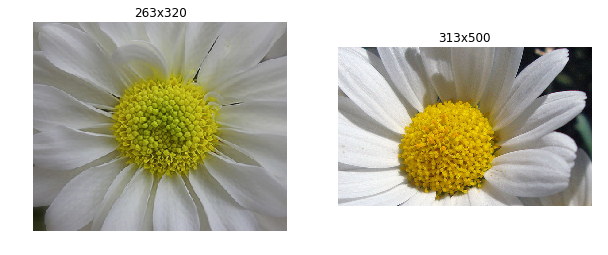

Class: dandelion


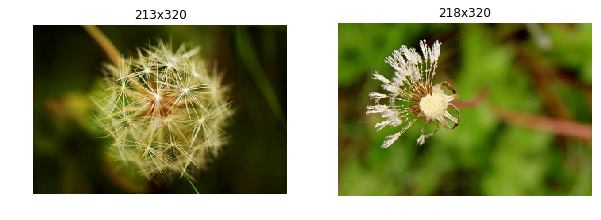

Class: roses


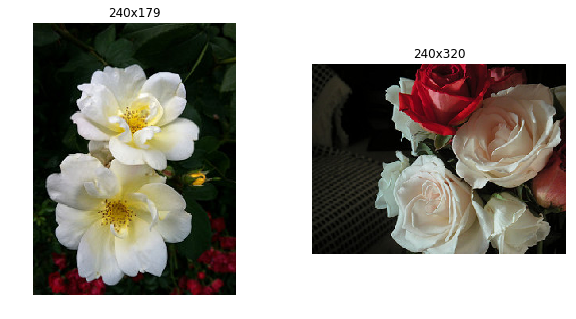

Class: sunflowers


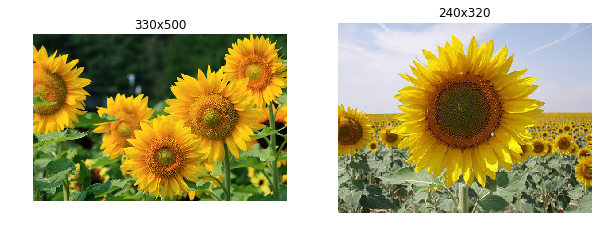

Class: tulips


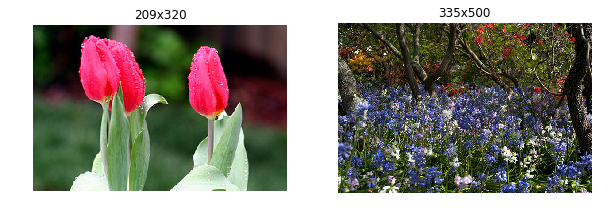

In [44]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    # For key=flower_class and grab up to but not including
    # 2 paths
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        # Read the image using mpimg.imread
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        # Subplot where first digit is number of rows, second digit
        # is the number of columns, and the last is image in leftmost
        # column
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[0], example_image.shape[1]))
        plt.imshow(example_image)
        plt.axis("off")
    # Will show new subplot for each class
    plt.show()

Above, we can see that the image dimensions vary and how difficult the classification task is especially with the tulip image on the right. 

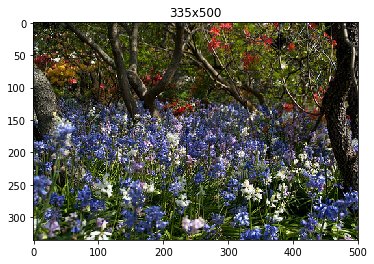

In [62]:
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[0], example_image.shape[1]))
plt.show()

Let's write a pre-processing step that will resize and crop the image to $299x299$. Let's add some randomness for data augmentation as well. 

First let's implement in NumPy.

In [187]:
from scipy.misc import imresize

def prepare_image_with_numpy(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    
    # Let's do this in NumPy for the last example image 
    # height = 335
    height = image.shape[0]
    # width = 500 
    width = image.shape[1]
    # image_ratio = 1.492537313432836
    image_ratio = width/height
    # target_image_ratio = 1
    target_image_ratio = target_width/target_height
    
    # Do we crop vertically?
    crop_vertically = image_ratio < target_image_ratio
    
    # We are cropping the width such that the crop_width = 335
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width/target_image_ratio) if crop_vertically else height
    
    # Let's shrink the bounding box by a random factor dividing
    # dimensions by a random number between 
    # 1.0 and 1.0 + max_zoom=0.2
    # Resize factor will depend on np.random.rand(), which is 
    # uniform distribution between 0 and 1
    resize_factor = np.random.rand() * max_zoom + 1.0
    
    # Resize both the crop width, heights
    crop_width = int(crop_width/resize_factor)
    crop_height = int(crop_height/resize_factor)
    
    # Let's select a random initial for the lower, left corner 
    # of bounding box, left lower corner
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    # Let's select the final point
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built
    image = image[y0:y1, x0:x1]
    
    # Let's flip the image horizontally with 50% probability for 
    # some data augmentation
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        
    # Let's resize the image to the target dimensions
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented
    # as 32-bit floats raning from 0.0 to 1.0 
    return image.astype(np.float32) / 255

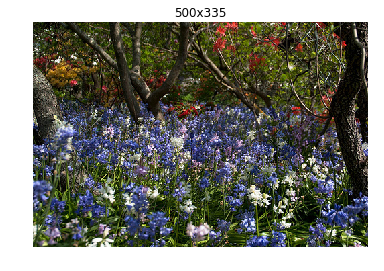

In [115]:
plt.figure(figsize=(6,8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

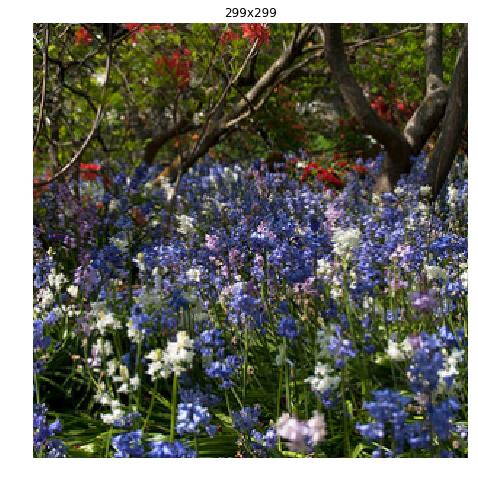

In [116]:
prepared_image = prepare_image_with_numpy(example_image)

plt.figure(figsize=(8,8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[0], prepared_image.shape[1]))
plt.axis("off")
plt.show()

Looks good. At test time, we want the pre-processing step to be small enough that we can feed it into our neural network. If we are not training, then we there may not be a need to flip the image and the minimum cropping for preserving the center of the image is required. 

We can generate a few other random images from the same original image. 

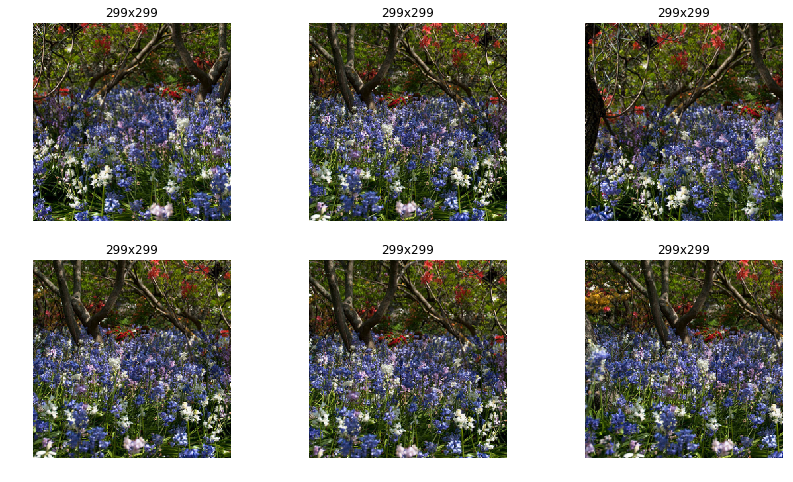

In [119]:
rows, cols = 2, 3
plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image_with_numpy(example_image)
        plt.subplot(rows, cols, row * cols + col + 1 )
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()


Looks good! Let's do this preprocessing step in Tensorflow using the `tf.image` module! Remember this function below will create the set of operations that perform the preprocessing when we run the Tensorflow graph.  

In [126]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width/height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    
    # If the condition is True, then run lambda: fn1, 
    # else lambda: fn2 
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Let's shrink this bounding box by a random factor
    # between 1.0 and 1.0 + 'max_zoom'.
    # Let's generate a random number using a unifrom distribution
    # Note: this placeholder expects single scalar value
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    # Let's crete the bounding box size by stacking along 
    # first dim.
    box_size = tf.stack([crop_height, crop_width, 3])
    
    # Let's now crop the image using the random bounding box
    # we computed. 
    image = tf.random_crop(image, box_size)
    
    # Let's flip horizontally with %50 probability
    image = tf.image.random_flip_left_right(image)
    
    # Resize function requires a 4-D tensor (batch of images)
    # Expand the dimensions, this will the dimension at the
    # zeroth index. 
    image_batch = tf.expand_dims(image, 0)
    
    # Let's resize the image to th target dimensions. This
    # function will return a float32 tensor. 
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    # Back to single image, scale colors from 0.0 to 1.0
    image = image_batch[0] / 255
    #image = image_batch[0] 
    return image
    

Let's test the Tensorflow implementation.

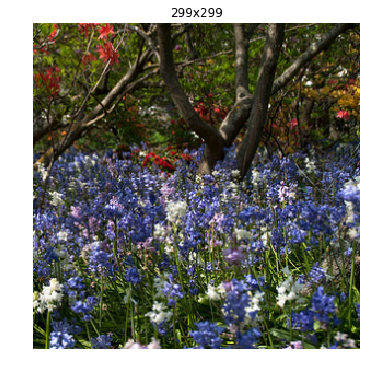

In [127]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image:example_image})
    
plt.figure(figsize=(6,6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Looks great!

Now let's used the pretrained Inception version 3. Let's freeze all layers up to the bottleneck layer (the last layer before the output layer) and replace the output layer with the correct number of outputs for your specific classification task. The flowers dataset had five mutually exclusive classes so the output layer has five neurons and use the softmax activation function.

Let's fetch the Inception version 3 graph again. Use the `training` placeholder to tell Tensorflow whether we are training the network or not (needed by operations like droput and batch normalization). 


In [188]:
height = 299
width = 299
channels = 3

In [189]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

`end_points` are  a set of activations for external use, for example summaries or losses. `end_points` will collect the relevant activations. 


We need to find the point in the graph where we should attach the new output layer. It should be the layer right before the current output layer. Let's do this by exploring the output layer's inputs.

In [133]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

Nope, above is part of the output layer where we add biases. A good way to visualize this is to use TensorBoard. Let's continue going backwards in the the graph. 

In [135]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

Also part of the output layer, the final layer in the inception layer. Let's continue.

In [137]:
logits.op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Identity:0' shape=(?, 1, 1, 2048) dtype=float32>

Ok, this is the layer we're looking for. The droput layer. This is the very last layer before the output layer in the network and so the layer we need to build on. 

There is a simpler way to do this using the `endpoints` function which returns a dict of end points for the model. 

In [138]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

We can see that "PreLogits" looks like the end point we want to focus on. Let's verify this. 

In [139]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

Let's drop the 2nd and 3rd dimension using the `tf.squeeze()` function. which we can specify with the `axis` so this can be an input to our FC layer.

In [190]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1,2])

Let's now add the fully connected layer on top of this layer. 

In [191]:
# Will return 5 classes
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    # Maps logistic values {-inf, +inf} to prob {0, 1}
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

Let's implement our usual code for training. This process is:
 - create a placeholder for the targets, y,
 - define the loss function, which is cross-entropy since it's classification task,
 - define an optimizer, that will minimize the cost functio,n
 - a couple operations to measure the model's accuracy,
 - an initializer and saver. 
 
Since we want to only train the output layer (all other layers must be frozen) and we must pass the list of variables to train to the optimizer's `minimize()` method.  

In [192]:
y = tf.placeholder(tf.int32, shape = [None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [193]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

We created a saver for the inception network before we adding the new output layer. We will use this saver to restore the pretrained model state. WE don't want to it to try and restore new variable or we would get an error that it does not know the new variables. 

Let's now split out dataset into training set and test set. Traing hte model on the training set and evaluate it on the test set. Let's first represent the classes as ints instead of strings. We can do this by using a dict. 

In [194]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Let's instead shuffle the dataset by representing as a list of filepath/class pairs. 

In [195]:
flower_class_ids.items()

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])

It's easier to shuffle the dataset if we represent it as a filepath/class pair.

In [196]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

Now, let's shuffle the dataset and split it into a training set and test set. 

In [197]:
len(flower_paths_and_classes)

3670

In [198]:
test_ratio = 0.2
# This will take the 80% of the data set
train_size = int(len(flower_paths_and_classes)*(1 - test_ratio))

# Let's randomly shuffle the data
np.random.shuffle(flower_paths_and_classes)

# Training set 
flower_paths_and_classes_train = flower_paths_and_classes[:train_size]

# Testing set
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

Let's look at the first 5 instances of the training set.

In [199]:
flower_paths_and_classes_train[:5]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4),
 ('datasets/flowers/flower_photos/dandelion/3446018470_0c40e73ed6_m.jpg', 1),
 ('datasets/flowers/flower_photos/dandelion/3533075436_0954145b9f_m.jpg', 1)]

In [174]:
from random import sample

batch_paths_and_classes = sample(flower_paths_and_classes, 4)
y_batch = np.array([labels for ,labels in batch_paths_and_classes])
y_batch

array([2, 1, 1, 0])

Let's create a function to preprocess a set of images. This will be usefule for preprocessing the test set and to create batches during training. 

In [200]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    # Will return a random sequence with size=batch_size of unique
    # elements with no replacement from population
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    # Returns a number of images equal to the batch_size
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    # Perform some data augmentation
    prepared_images = [prepare_image_with_numpy(image) for image in images]
    # Stack iamges and then broadcast to each, this is because
    # Inception networks expects colors raning from -1 to 1
    X_batch = 2 * np.stack(prepared_images) - 1
    # Returns a label for each instance in a batch, which is then put into an array 
    # of length batch size
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [201]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [202]:
X_batch.shape

(4, 299, 299, 3)

In [203]:
X_batch.dtype

dtype('float32')

In [204]:
y_batch.shape

(4,)

In [205]:
y_batch.dtype

dtype('int32')

This looks great! 

Let's now prepare out test set. 

In [206]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size = len(flower_paths_and_classes_test))

/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [207]:
X_test.shape

(734, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [208]:
n_epochs = 10
batch_size = 40
# floor((num_of_instances)/ batch size)
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Last batch accuracy:", acc_batch)

        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.

/Users/aocoe/working/handsonml/env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


........................................................................  Last batch accuracy: 0.6
Epoch 1.........................................................................  Last batch accuracy: 0.65
Epoch 2.........................................................................  Last batch accuracy: 0.625
Epoch 3.........................................................................  Last batch accuracy: 0.6
Epoch 4.........................................................................  Last batch accuracy: 0.675
Epoch 5.........................................................................  Last batch accuracy: 0.675
Epoch 6.........................................................................  Last batch accuracy: 0.65
Epoch 7.........................................................................  Last batch accuracy: 0.675
Epoch 8.........................................................................  Last batch accuracy: 0.725
Epoch 9..........................

Now, that we're trained our model let's see how it performs on the test data. Here we split the test data into batches of 10. We use `zip` here to feed each batch to to evaluate the accuracy (returns a !-D tensor) and take the mean to get the final accuracy.

In [222]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")
    
    print("Computing the final accuracy.......................")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing the final accuracy.......................
Test accuracy: 0.71121806


We get a test accuracy here of $71\%$ which is still low. This was run with only $10$ epochs and frozen lower layers. If we were to run it on a GPU, we can try to run the training step much longer (use early stopping). Can also improve the preprocessing function (changing the hue, rotating the image slightly). Here's a great blog for fine-tuning your model https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html

### References

1. https://www.tensorflow.org/guide/
2. Geron, Aurelion. *Hands On Machine Learning With Sci-Kit Learn and Tensorflow*. O'Reilly, 2016.
3. http://cs231n.stanford.edu/